# Step3. Feature Engineering and Model Selection
  
Goal:
- By the end of this notebook, the best model will be decided
  
Objectives:
- [x] Split up data into TRAIN and TEST sets
- [x] Examine learning curves to see how a simple model performs with the current number of observation
- [x] Investigate which linear regression models to use, with or without regularization


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import power_transform
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from ScrapeProcFunc import *

import warnings
warnings.simplefilter('ignore')

In [2]:
# Import dataset
df = pd.read_csv('./data/Allplayers.csv', index_col=0)

In [3]:
df.sample()

,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_QB,pos_RB,pos_WR,draftStat_No,draftStat_Yes,Salary_log1p
97,4,71,219,4.4,76.0,0.2,51.4,27.6,0,1,0,0,1,14.173885


- Specify columns to use 
- Drop dummy variables

In [4]:
# Select columns to use or NOT use
Xorig = df.drop(['pos_QB','draftStat_No', 'Salary_log1p'],axis=1)
yorig = df['Salary_log1p']

print(Xorig.shape)
Xorig.sample()

(356, 11)


,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_RB,pos_WR,draftStat_Yes
48,5,75,195,4.58,0.3,18.5,25.4,0.0,0,0,1


___


### Start Splitting: TRAIN, VALIDATION, TEST

In [5]:
# Hold out 20% of the data for final testing: TRAIN and TEST
Xt, X_test, yt, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)

# Split TRAIN and VALIDATION 
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(Xt, yt, test_size=.25, random_state=3)

In [6]:
print('size of all observations: ', Xorig.shape)
print('size of training set    : ', X_train_t.shape)
print('size of validation set  : ', X_val_t.shape)
print('size of testing set     : ', X_test.shape)

size of all observations:  (356, 11)
size of training set    :  (213, 11)
size of validation set  :  (71, 11)
size of testing set     :  (72, 11)


### Plot Learning Curves, to see if our model performs ok under 356 observations 

In [7]:
# Standard Scaling features
sc = StandardScaler()
sc.fit(X_train_t.values)
X_train_t_sc = sc.transform(X_train_t.values)
X_val_t_sc = sc.transform(X_val_t.values)

In [10]:
# Instantiate Linear Regressor
lr = LinearRegression()
lr.fit(X_train_t_sc, y_train_t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

<Figure size 432x288 with 0 Axes>

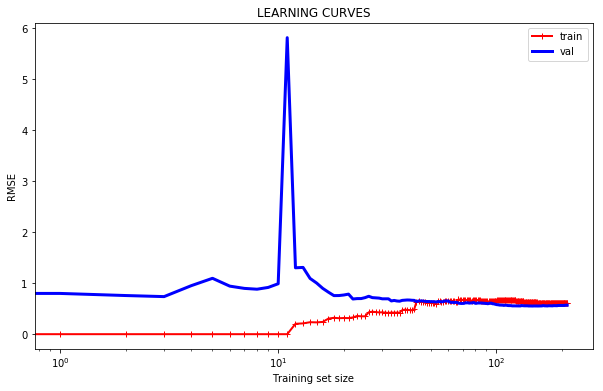

In [11]:
# Checking Learning Curves
fig = plt.figure()
plot_learning_curves(lr, X_train_t_sc, X_val_t_sc, y_train_t, y_val_t)
plt.xscale('log');
# plt.savefig('./figures/learningCurves_log.png')

<Figure size 432x288 with 0 Axes>

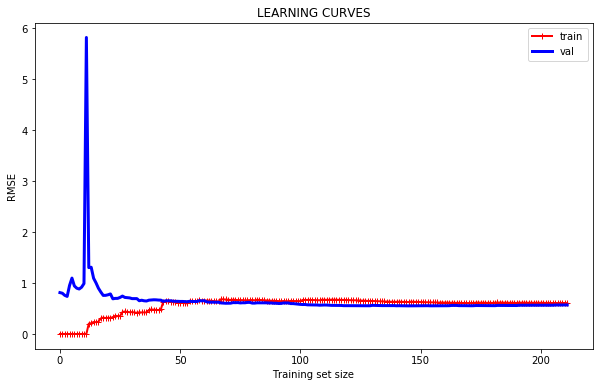

In [12]:
# Checking Learning Curves
fig = plt.figure(figsize=(6,4))
plot_learning_curves(lr, X_train_t_sc, X_val_t_sc, y_train_t, y_val_t)
# plt.savefig('./figures/learningCurves.png');

- The train and val curves converged, so we should be ok

---

### Do 10-fold Cross-Validation on Linear Regression

In [14]:
# Select columns to use or NOT use
Xorig = df.drop(['pos_QB','draftStat_No', 'Salary_log1p'],axis=1)
yorig = df['Salary_log1p']
print(Xorig.shape)
Xorig.sample()

(356, 11)


,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_RB,pos_WR,draftStat_Yes
10,7,68,237,4.47,2.2,65.1,0.0,31.9,1,0,1


In [15]:
# Hold out 20% of the data for final testing: TRAIN and TEST
X_train, X_test, y_train, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)


In [16]:
print('size of all observations: ', Xorig.shape)
print('size of training set    : ', X_train.shape)
print('size of testing set     : ', X_test.shape)

size of all observations:  (356, 11)
size of training set    :  (284, 11)
size of testing set     :  (72, 11)


In [17]:
# Standard scaling
sc = StandardScaler()
sc.fit(X_train.values)
X_train_sc = sc.transform(X_train)

In [19]:
# Try kfold and CV

kf = KFold(n_splits=10, shuffle=True, random_state = 71)
cv_score_r2 = cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring='r2')
cv_score_mse = cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring='neg_mean_squared_error')

print('r2   : ', cv_score_r2.mean())
print('rmse : ', np.sqrt(-cv_score_mse).mean())
    

r2   :  0.28489489400160434
rmse :  0.6120823866384806


---

### Plotting residuals in the simple LR model
- Check for odd patterns in the residuals

In [20]:
# Standard Scaling
sc = StandardScaler()
sc.fit(X_train.values)
X_train_sc = sc.transform(X_train)

In [21]:
# Simple Linear Regression
lr = LinearRegression()
lr.fit(X_train_sc, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

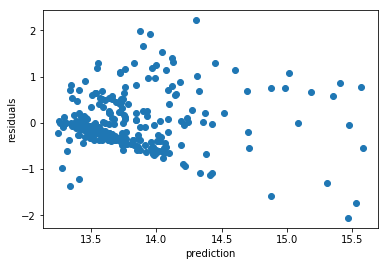

In [22]:
# Residuals of the training data
y_train_pred = lr.predict(X_train_sc)
residuals = y_train - y_train_pred

fig = plt.figure()
plt.plot(y_train_pred, residuals, 'o')
plt.ylabel('residuals')
plt.xlabel('prediction');
# fig.savefig('./figures/residuals_train_model.png')

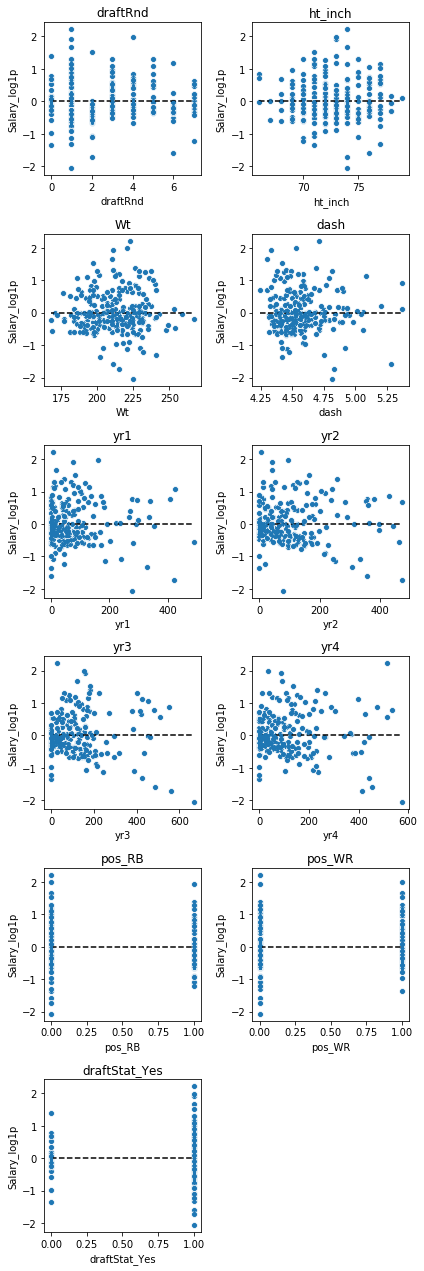

In [23]:
# Plot residuals vs features

labels = list(X_train.columns) 
# Residuals
fig =plt.figure(figsize=(6,32))

for ind, col in enumerate(range(X_train.shape[1])):    
    plt.subplot(X_train.shape[1],2,ind+1)
    sns.scatterplot(X_train.iloc[:,col], residuals)
    plt.plot(X_train.iloc[:,col], residuals, 'o',markersize=2)
    plt.title(labels[ind] )
    plt.hlines(0, X_train.iloc[:,col].min(),X_train.iloc[:,col].max(), linestyles='--')
plt.tight_layout()
# fig.savefig('./figures/residuals_train_vs_variables')

**Observations**:
- There is some heteroskedacity in the residual plots, e.g., on yr1, yr2, etc.
- Transformations of these variables are needed

---

### Transformations of Variables
- try to transform some features that do not adopt normality

In [24]:
def compareHist(x_normal, x_transformed):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.hist(x_normal)
    plt.title('normal')
    plt.subplot(1,2,2)
    plt.hist(x_transformed)
    plt.title('transformed')

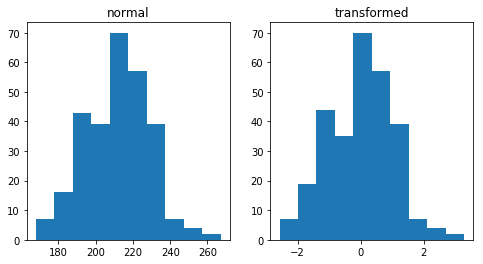

In [25]:
#  Check the Distribution of weight
Wt_pt = power_transform(np.asarray(X_train['Wt']).reshape(-1,1),method='yeo-johnson' )
compareHist(X_train.Wt, Wt_pt)
# plt.savefig('./figures/transform_weight.png')

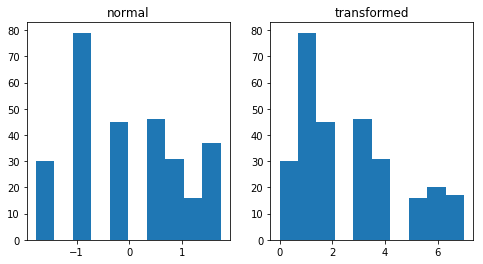

In [26]:
# Check the Draft Round 
draftRnd_pt = power_transform(np.asarray(X_train['draftRnd']).reshape(-1,1),method='yeo-johnson' )
compareHist(draftRnd_pt, X_train.draftRnd)
# plt.savefig('./figures/transform_Rnd.png')

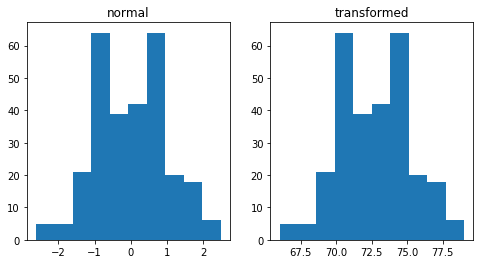

In [27]:
# Check distribution of Height
htinch_pt = power_transform(np.asarray(X_train['ht_inch']).reshape(-1,1),method='box-cox' )
compareHist(htinch_pt, X_train['ht_inch'])

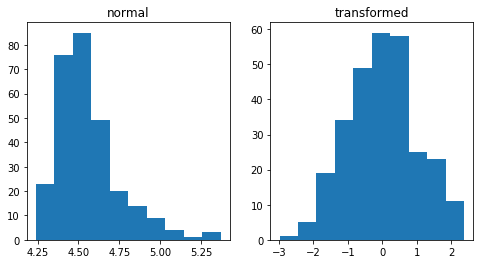

In [28]:
# Check out the distribution of dash
dash_pt = power_transform(np.asarray(X_train['dash']).reshape(-1,1),method='box-cox' )
compareHist(X_train.dash, dash_pt)
# plt.savefig('./figures/transform_dash.png')

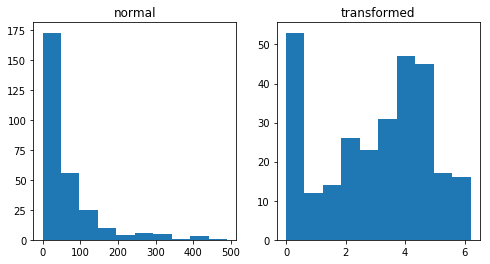

In [29]:
# Checkout the performance of YR1 after doing log transformation
yr1_log = np.log1p(X_train.yr1)
compareHist(X_train.yr1, yr1_log)
# plt.savefig('./figures/transform_yr1.png')

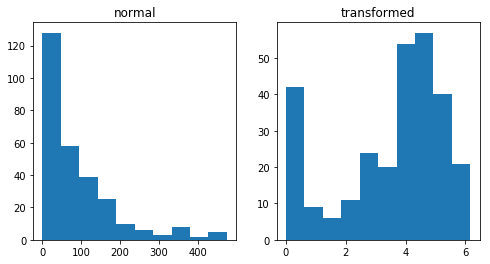

In [30]:
# Checkout the performance of YR2 after doing log transformation
yr2_log = np.log1p(X_train.yr2)
compareHist(X_train.yr2, yr2_log)
# plt.savefig('./figures/transform_yr2.png')

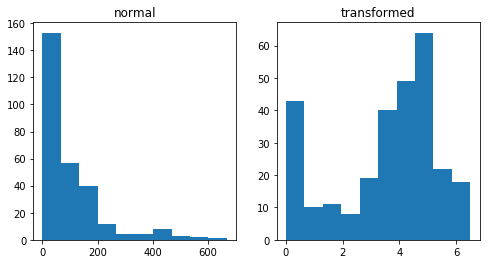

In [31]:
# Checkout the performance of YR3 after doing log transformation
yr3_log = np.log1p(X_train.yr3)
compareHist(X_train.yr3, yr3_log)
# plt.savefig('./figures/transform_yr3.png')


<Figure size 432x288 with 0 Axes>

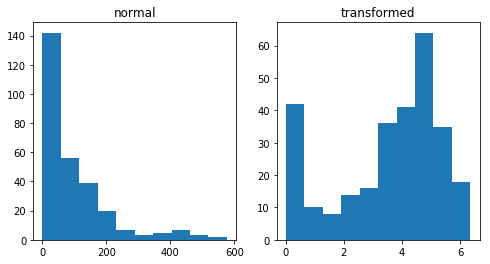

In [32]:
# Checkout the performance of YR4 after doing log transformation
fig = plt.figure()
yr4_log = np.log1p(X_train.yr4)
compareHist(X_train.yr4, yr4_log)
# plt.savefig('./figures/transform_yr4.png')

**Notes**:
- Looks like applying log1p transformation on yr1,yr2, etc. made their distributions normal-ish. However, there's still huge amnt of zeros
- Some other features need other types of transformations, e.g., box-cox for the 'dash' variable

---

### Making a copy of the dataframe with transformed features

In [33]:
# Make a new copy of dataframe 
df_final = df.copy()

In [34]:
# TRANSFORMATION LIST
df_final['draftRnd_yj'] = power_transform(np.asarray(df_final['draftRnd']).reshape(-1,1), method='yeo-johnson')
df_final['yr1_l1p'] = np.log1p(df.yr1)
df_final['yr2_l1p'] = np.log1p(df.yr2)
df_final['yr3_l1p'] = np.log1p(df.yr3)
df_final['yr4_l1p'] = np.log1p(df.yr4)
df_final['dash_bc'] = power_transform(np.asarray(df_final['dash']).reshape(-1,1), method='box-cox')


In [35]:
# Select columns to use or NOT use

Xorig = df_final[['yr1_l1p','yr2_l1p','yr3_l1p','yr4_l1p','dash_bc','Wt','ht_inch','draftRnd_yj',
                  'pos_RB','pos_WR','draftStat_Yes']]
yorig = df_final['Salary_log1p']
                  
print(Xorig.shape)
Xorig.sample()

(356, 11)


,yr1_l1p,yr2_l1p,yr3_l1p,yr4_l1p,dash_bc,Wt,ht_inch,draftRnd_yj,pos_RB,pos_WR,draftStat_Yes
97,4.343805,0.182322,3.958907,3.353407,-1.01341,219,71,0.792828,1,0,1


---

### Find the best alphas for regularizations, using LassoCV and RidgeCV

In [38]:
# Feature scale our X's 
scaler= StandardScaler()
scaler.fit(X_train.values) #<< Only fit the X_train

X_train_sc = scaler.transform(X_train.values)

In [39]:
alphavec = 10**np.linspace(-4,4,200)

lasso_model = LassoCV(alphas = alphavec, cv=10,)
lasso_model.fit(X_train_sc, y_train)

ridge_model = RidgeCV(alphas = alphavec, cv=10, )
ridge_model.fit(X_train_sc, y_train)

eln_model = ElasticNetCV(alphas = alphavec, cv=10, )
eln_model.fit(X_train_sc, y_train)

ElasticNetCV(alphas=array([1.00000e-04, 1.09699e-04, ..., 9.11589e+03, 1.00000e+04]),
       copy_X=True, cv=10, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [40]:
best_alpha_lasso = lasso_model.alpha_
best_alpha_lasso

0.03409285069746811

In [41]:
best_alpha_ridge = ridge_model.alpha_
best_alpha_ridge

246.5811075822604

In [42]:
best_alpha_eln = eln_model.alpha_
best_alpha_eln

0.07842822061337681

### NOW, apply different learning models on the dataset

In [43]:
# Make Dictionary of different models
models = {
        'LR': LinearRegression(),
        'LR-lasso': Lasso(best_alpha_lasso),
        'LR-ridge': Ridge(best_alpha_ridge),
        'Eln' : ElasticNet(best_alpha_eln),
        'RandForest': RandomForestRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'Bagging' : BaggingRegressor(),
         }
         

# Parameters
seed = 7
scoring = 'neg_mean_squared_error'

# Evaluation
results =[]
names =[]
summary=[]
residuals = []


for name, model in models.items():
    
    # Setup Kfold and CV
    kfold = KFold(n_splits=10, random_state= seed)
    cv_results = cross_val_score(model, X_train_sc, y_train, cv= kfold, scoring=scoring)
    
    results.append(cv_results)
    names.append(name)
    
    # Setup summary table
    for fold_id, cv in enumerate(cv_results):
        summary.append((name, fold_id,  np.sqrt(-cv)))

    msg = "CV for %s: %f std(%f)" %(name, np.sqrt(-cv_results).mean(), cv_results.std())
    print(msg)
    
df_sum = pd.DataFrame(summary, columns=['names', 'fold_idx', 'rmse'])

CV for LR: 0.627757 std(0.144712)
CV for LR-lasso: 0.618014 std(0.145473)
CV for LR-ridge: 0.615051 std(0.126959)
CV for Eln: 0.616572 std(0.142806)
CV for RandForest: 0.634020 std(0.124780)
CV for DecisionTree: 0.906804 std(0.220575)
CV for Bagging: 0.651534 std(0.169620)


In [44]:
df_sum.sample(5)

,names,fold_idx,rmse
50,DecisionTree,0,0.809872
10,LR-lasso,0,0.557806
49,RandForest,9,0.608344
5,LR,5,0.471171
8,LR,8,0.616467


In [45]:
# Which one performs best?
df_sum.groupby('names')[['rmse']].mean().sort_values(by='rmse',ascending=True)

,rmse
names,
LR-ridge,0.615051
Eln,0.616572
LR-lasso,0.618014
LR,0.627757
RandForest,0.634020
Bagging,0.651534
DecisionTree,0.906804


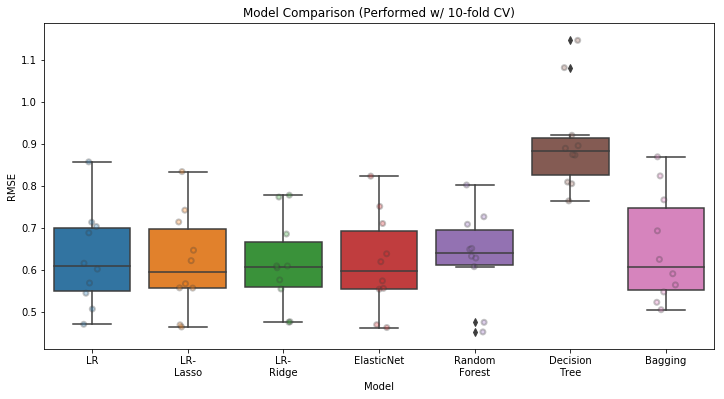

In [46]:
# Plotting the performance of algorithms

fig = plt.figure(figsize=(12,6))
sns.boxplot(x = 'names', y= 'rmse', data=df_sum)
sns.stripplot(x= 'names', y= 'rmse', data=df_sum, jitter=True, edgecolor="gray", alpha = 0.3,linewidth=2)

# plt.hlines(df_R2.groupby('names').mean().loc[['LR-lasso']].accuracy, -1, 8, linestyles='dotted')
plt.title('Model Comparison (Performed w/ 10-fold CV)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(range(0,7),['LR','LR-\nLasso','LR-\nRidge','ElasticNet','Random\nForest','Decision\nTree',
                      'Bagging']);
# plt.grid(which='major', axis='y',)
# fig.savefig('Compare10fold-2.png', bbox_inches='tight')
# plt.show()
# fig.savefig('./figures/Alg_comparison_RMSE.png')

- The performance of linear regression models (w/ & w/o regularizations) are fairly similar
- Linear regressors are still better than tree-based regressors, at least out of the box (w/o Hyperparametric tuning)

---

### Which features are important according to Random Forest?

In [47]:
# Investigate look at features of importance in Random Forest Regressor
RF = RandomForestRegressor()
RF.fit(X_train_sc,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
df_rf = pd.DataFrame(np.c_[list(X_train.columns), list(RF.feature_importances_)], columns =['Features','Importance'])
df_rf['Importance'] = df_rf['Importance'].astype(float)
df_rf.sort_values(by='Importance', ascending=False)

,Features,Importance
6,yr3,0.339033
7,yr4,0.180501
5,yr2,0.096417
4,yr1,0.093718
3,dash,0.069632
0,draftRnd,0.068555
1,ht_inch,0.062043
2,Wt,0.061955
8,pos_RB,0.018305
9,pos_WR,0.008179


Text(0.5, 0, 'Importance')

<Figure size 432x288 with 0 Axes>

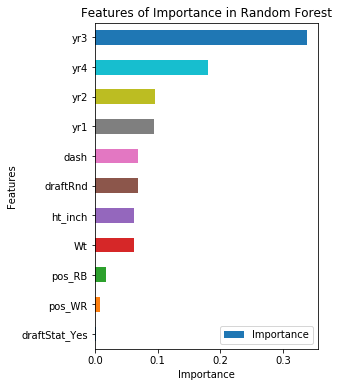

In [49]:
# Plot features of importance
fig=plt.figure()
df_rf.sort_values(by='Importance',ascending=True).plot.barh(x='Features',y='Importance',
                                                            figsize=(4,6))
plt.legend(loc='lower right')
plt.title('Features of Importance in Random Forest')
plt.xlabel('Importance')
# plt.savefig('./figures/RF_featuresImportance.png')

- It seems to make sense, players' Year3 and Year4 performance are the most important factor in the model's salary prediction 

---

### Try investigate R2 among different models

In [50]:
# Make Dictionary of different models
models = {
        'LR': LinearRegression(),
        'LR-lasso': Lasso(best_alpha_lasso),
        'LR-ridge': Ridge(best_alpha_ridge),
        'Eln' : ElasticNet(best_alpha_eln),
        'RandForest': RandomForestRegressor(),
        'DecisionTreeRegressor': DecisionTreeRegressor(),
        'Bagging' : BaggingRegressor(),
#         'DecisionTree': DecisionTreeRegressor()
         }
         
# Parameters
seed = 7
scoring = 'r2'

# Evaluation
results =[]
names =[]
summary=[]
residuals = []


for name, model in models.items():
    
    # Setup Kfold and CV
    kfold = KFold(n_splits=10, random_state= seed)
    cv_results = cross_val_score(model, X_train_sc, y_train, cv= kfold, scoring=scoring)
    
    results.append(cv_results)
    names.append(name)
    
    # Setup summary table
    for fold_id, cv in enumerate(cv_results):
        summary.append((name, fold_id,  cv))

    msg = "CV for %s: %f std(%f)" %(name, cv_results.mean(), cv_results.std())
    print(msg)
    
df_sum = pd.DataFrame(summary, columns=['names', 'fold_idx', 'r2'])

CV for LR: 0.152111 std(0.293704)
CV for LR-lasso: 0.196092 std(0.241185)
CV for LR-ridge: 0.214901 std(0.181721)
CV for Eln: 0.202783 std(0.229288)
CV for RandForest: 0.111636 std(0.307622)
CV for DecisionTreeRegressor: -0.722706 std(0.698163)
CV for Bagging: 0.049735 std(0.319320)


In [51]:
df_sum.groupby('names')[['r2']].mean().sort_values(by='r2',ascending=False)

,r2
names,
LR-ridge,0.214901
Eln,0.202783
LR-lasso,0.196092
LR,0.152111
RandForest,0.111636
Bagging,0.049735
DecisionTreeRegressor,-0.722706


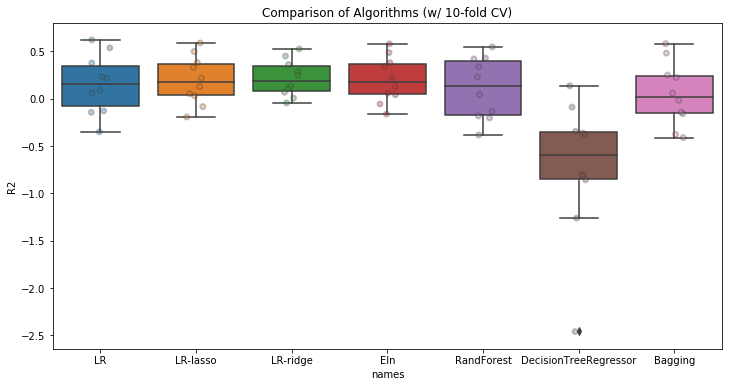

In [52]:
# Comparing the performance of algorithms

fig = plt.figure(figsize=(12,6))
sns.boxplot(x = 'names', y= 'r2', data=df_sum)
sns.stripplot(x= 'names', y= 'r2', data=df_sum, jitter=True, edgecolor="gray", alpha = 0.3,linewidth=2)

# plt.hlines(df_R2.groupby('names').mean().loc[['LR-lasso']].accuracy, -1, 8, linestyles='dotted')
plt.title('Comparison of Algorithms (w/ 10-fold CV)')
plt.ylabel('R2')
# plt.grid(which='major', axis='y',)
# fig.savefig('Compare10fold-2.png', bbox_inches='tight')
plt.show()
# fig.savefig('./figures/Alg_comparison_r2.png')

- Consistent with the previous plot, linear regressors have better R2 values than tree-based models 

---

Notes:
- All Linear Regression Models are generally comparable
- However, the ridge regression has smaller standard deviation
- Let's just pick the simplest linear regression model (unregularized)

---